# Проект:

# Аналитика в сервисе по продаже билетов

<font style="color:DeepPink; font-size:400%">•</font> **Загрузим данные и подготовим их к анализу.**

In [0]:
import pandas as pd
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [0]:
# Приведем названия столбцов к единообразию (уберем пробелы, и заглавные буквы) и приведем столбцы с датами к формату дат

visits.set_axis(['uid', 'device', 'end_ts', 'source_id', 'start_ts'], axis = 'columns', inplace = True)
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%d.%m.%Y %H:%M')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%d.%m.%Y %H:%M')

orders.columns = ['order_date', 'revenue', 'uid']
orders['order_date'] = pd.to_datetime(orders['order_date'], format='%Y-%m-%d %H:%M:%S')

costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

In [0]:
visits.head()

,uid,device,end_ts,source_id,start_ts
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00


In [0]:
orders.head()

,order_date,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [0]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<font style="color:#39B3E5; font-size:400%">•</font> **Построим отчеты и метрики**

<font style="color:#92D3EE; font-size:200%">•</font> **Продукт**

<font style="color:#92D3EE; font-size:200%">•</font> Сколько людей пользуются в день, неделю, месяц?

In [0]:
#создадим столбцы с годом, месяцем, неделей и датой начала сессии
visits['year'] = visits['start_ts'].dt.year
visits['month'] = visits['start_ts'].dt.month
visits['week'] = visits['start_ts'].dt.week
visits['date'] = visits['start_ts'].astype('datetime64[D]')

Рассчитаем:  
* DAU *(от англ. daily active users)* — количество уникальных пользователей в день;
* WAU *(от англ. weekly active users)* — количество уникальных пользователей в неделю;
* MAU *(от англ. monthly active users)* — количество уникальных пользователей в месяц.


Text(0.5, 1.0, 'DAU')

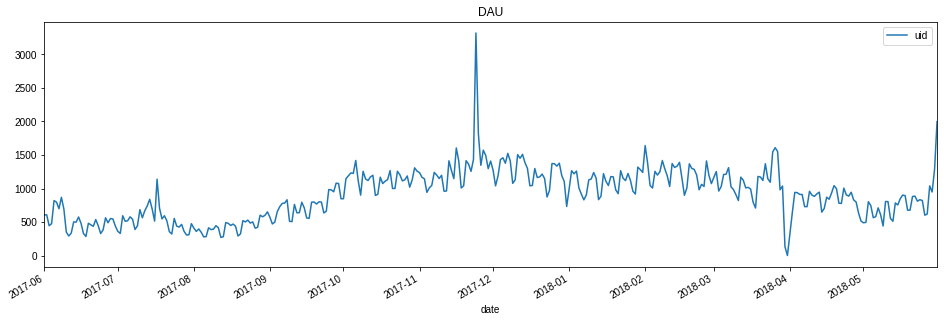

In [0]:
dau_df = visits.groupby('date').agg({'uid': 'nunique'})
dau_df.plot(style='-', y='uid', figsize=(16, 5))

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.title('DAU')

В конце ноября 2017 был всплеск количества уникальных пользователей в день, в конце марта 2018 провал.

In [0]:
# WAU не будем печатать, график рваный и неинформативный
wau_df = visits.groupby(['year', 'week']).agg({'uid': 'nunique'})
#wau_df.plot(style='-', y='uid', figsize=(16, 5))
#plt.title('WAU')

Text(0.5, 1.0, 'MAU')

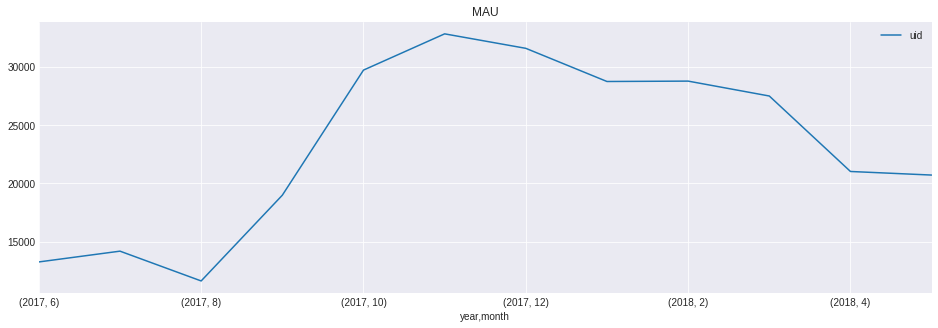

In [0]:
mau_df = visits.groupby(['year', 'month']).agg({'uid': 'nunique'})
mau_df.plot(style='-', y='uid', figsize=(16, 5))
plt.title('MAU')

В количестве уникальных посетителей в месяц:
* есть минимум в августе 2017 до 11 631, 
* пик в ноябре 2018 до 32 797,  
после чего выходит на ровное плато ~ 20 000 уникальных посетителей в месяц. 

In [0]:
dau_total = dau_df.mean()
wau_total = wau_df.mean()
mau_total = mau_df.mean()

In [0]:
print('Средний dau: {}'.format(int(dau_total)))
print('Средний wau: {}'.format(int(wau_total)))
print('Средний mau: {}'.format(int(mau_total)))

Средний dau: 907
Средний wau: 5716
Средний mau: 23228


Посмотрим, как часто пользователи обращаются к приложению. Для этого рассчитаем sticky factor.  

In [0]:
sticky_wau = dau_total / wau_total *100
sticky_mau = dau_total / mau_total *100

print('Sticky factor wau: {}'.format(sticky_wau))
print('Sticky factor mau: {}'.format(sticky_mau))

Sticky factor wau: uid    15.884409
dtype: float64
Sticky factor mau: uid    3.90897
dtype: float64


16% пользователей заходят в приложение каждую неделю, 4% каждый месяц.

<font style="color:#92D3EE; font-size:200%">•</font> Сколько сессий в день?

In [0]:
# Посчитаем количество уникальных пользователей и сессий в день

sessions_per_user = visits.groupby(['date']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']

# Посчитаем среднееколичество сессий на пользователя

sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user.head()

,n_sessions,n_users,sess_per_user
date,,,
2017-06-01,661,605,1.092562
2017-06-02,653,608,1.074013
2017-06-03,476,445,1.069663
2017-06-04,508,476,1.067227
2017-06-05,887,820,1.081707


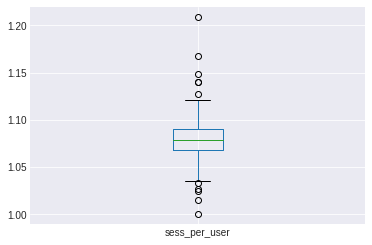

In [0]:
# посмотрим на боксплот среднего количества сессий на пользователя

sessions_per_user[['sess_per_user']].boxplot()

Один пользователь заходит в приложение в среднем один раз в день.

<font style="color:#92D3EE; font-size:200%">•</font> Сколько длится одна сессия?

In [0]:
# Посчитаем длину всех сессий в секундах
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

Посмотрим на распределение значений.

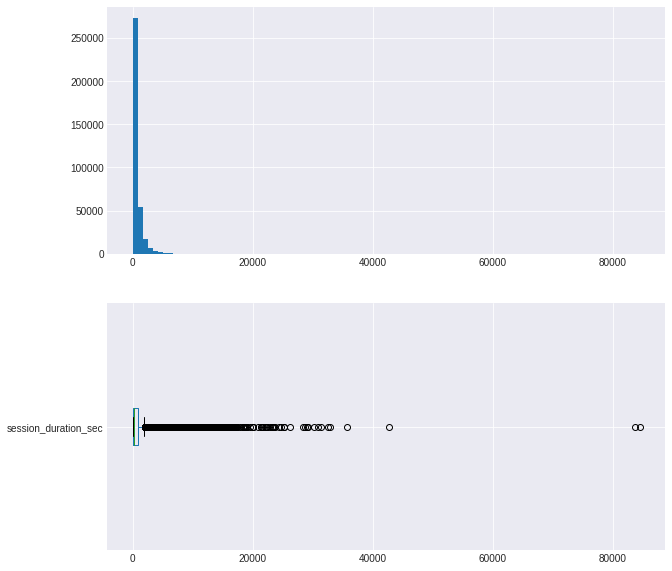

In [0]:
plt.subplots(figsize = (10, 10))
plot = (visits['session_duration_sec']
        .hist(bins=100, ax = plt.subplot(2, 1, 1))
       )
plot = (visits[['session_duration_sec']]
        .boxplot(vert=False, ax = plt.subplot(2, 1, 2))
       )

Когда распределение близко к нормальному или нормальное — можно смотреть на среднюю или медиану. Наше — не из таких, рассчитаем моду (значение в выборке, которое встречается чаще всего):

In [0]:
visits[['session_duration_sec']].mode()

,session_duration_sec
0,60


По моде сессия длится 1 минуту.

Также на гистограмме видно, что у нас достаточно много сессий продолжительностью 0 сек. Посмотрим на них.

In [0]:
visits.query('session_duration_sec == 0').head()

,uid,device,end_ts,source_id,start_ts,year,month,week,date,session_duration_sec
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,2017,7,26,2017-07-01,0
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,2017,12,52,2017-12-27,0
28,17892541477379911957,desktop,2017-11-09 15:53:00,4,2017-11-09 15:53:00,2017,11,45,2017-11-09,0
32,13410401624913285510,desktop,2017-11-30 12:29:00,4,2017-11-30 12:29:00,2017,11,48,2017-11-30,0
54,13423278602430425332,desktop,2018-02-23 16:52:00,10,2018-02-23 16:52:00,2018,2,8,2018-02-23,0


In [0]:
print('Сессий продолжительностью 0 сек в данных: {:.2%}'.format(len(visits.query('session_duration_sec == 0'))/len(visits)))

Сессий продолжительностью 0 сек в данных: 9.98%


Это может быть связано с логикой логгирования яндекс метрики: если пользователь зашел на стартовую страницу и больше не перешл на другие страницы и не совершил действий, метрика считает такие сессии продолжительности 0, они называются bounce-ами или отказами.

<font style="color:#92D3EE; font-size:200%">•</font> Как часто люди возвращаются?

Для того, чтобы определиться с этой метрикой, расчитывается Retention Rate.  
Этот показатель показывает, сколько пользователей из когорты относительно их изначального числа, вернулось в последующие периоды.  

*(Период может быть разным в зависимости от деятельности анализируемой кампании.  
В случае с мобильным приложением результаты изменений продукта так быстро сказываются на действиях пользователей, что новые решения надо принимать быстрее. А значит, формировать когорты по данным за неделю.)*

In [0]:
# Определяем дату первой сессии каждого пользователя

first_activity_date = visits.groupby(['uid'])['date'].min()
first_activity_date.name = 'first_activity_date'

# Добавляем ее отдельным столбцом в таблицу visits

visits = visits.join(first_activity_date, on='uid')

# Создаем столбец в котором отдельно выделим первую дату в неделе, на которой у пользователя была сессия 
# и также выделим в отдельный столбец дату первой сессии

visits['activity_week'] = pd.to_datetime(visits['date'], unit='d') - pd.to_timedelta(visits['date'].dt.dayofweek, \
                                                                                         unit='d')
visits['first_activity_week'] = pd.to_datetime(visits['first_activity_date'], unit='d') - \
pd.to_timedelta(visits['first_activity_date'].dt.dayofweek, unit='d')

In [0]:
visits[['uid', 'device', 'end_ts', 'source_id', 'start_ts', 'first_activity_date', 'activity_week', \
        'first_activity_week']].head()

,uid,device,end_ts,source_id,start_ts,first_activity_date,activity_week,first_activity_week
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,2017-12-20,2017-12-18,2017-12-18
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,2018-02-19,2018-02-19,2018-02-19
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,2017-07-01,2017-06-26,2017-06-26
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,2018-03-09,2018-05-14,2018-03-05
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,2017-12-27,2017-12-25,2017-12-25


In [0]:
# Рассчитаем для каждого пользователя lifetime в рамках когорты
import numpy as np
visits['cohort_lifetime'] = visits['activity_week'] - visits['first_activity_week']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'W')
visits['cohort_lifetime'] = visits['cohort_lifetime'].astype(int)

In [0]:
visits[['uid', 'device', 'end_ts', 'source_id', 'start_ts', 'first_activity_date', 'activity_week', 'first_activity_week', \
        'cohort_lifetime']].head()

,uid,device,end_ts,source_id,start_ts,first_activity_date,activity_week,first_activity_week,cohort_lifetime
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,2017-12-20,2017-12-18,2017-12-18,0
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,2018-02-19,2018-02-19,2018-02-19,0
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,2017-07-01,2017-06-26,2017-06-26,0
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,2018-03-09,2018-05-14,2018-03-05,10
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,2017-12-27,2017-12-25,2017-12-25,0


In [0]:
# Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённую
# «неделю жизни»:
cohorts = visits.groupby(['first_activity_week','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts.head()

,first_activity_week,cohort_lifetime,uid
0,2017-05-29,0,2021
1,2017-05-29,1,185
2,2017-05-29,2,98
3,2017-05-29,3,74
4,2017-05-29,4,88


In [0]:
# Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю

inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_week','uid']]

# Переименуем столбец uid в cohort_users

inital_users_count = inital_users_count.rename(columns={'uid':'cohort_users'})
inital_users_count.head()

,first_activity_week,cohort_users
0,2017-05-29,2021
53,2017-06-05,3944
105,2017-06-12,2567
156,2017-06-19,2585
206,2017-06-26,2717


In [0]:
# Объединим данные по когортам с исходным количеством пользователей в когорте:
cohorts = cohorts.merge(inital_users_count,on='first_activity_week')
cohorts.head()

,first_activity_week,cohort_lifetime,uid,cohort_users
0,2017-05-29,0,2021,2021
1,2017-05-29,1,185,2021
2,2017-05-29,2,98,2021
3,2017-05-29,3,74,2021
4,2017-05-29,4,88,2021


In [0]:
# Наконец, рассчитаем Retention Rate. Разделим количество активных пользователей в каждую из недель на исходное число 
# пользователей в когорте:

cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

# Создадим отдельный столбец с датой когорты в формате object, чтобы по нему строить красиво тепловую карту :)

cohorts['cohort'] = cohorts['first_activity_week'].dt.date
cohorts.head()

,first_activity_week,cohort_lifetime,uid,cohort_users,retention,cohort
0,2017-05-29,0,2021,2021,1.000000,2017-05-29
1,2017-05-29,1,185,2021,0.091539,2017-05-29
2,2017-05-29,2,98,2021,0.048491,2017-05-29
3,2017-05-29,3,74,2021,0.036616,2017-05-29
4,2017-05-29,4,88,2021,0.043543,2017-05-29


In [0]:
# Построим сводную таблицу и создадим тепловую карту:
retention_pivot = cohorts.round({'retention':2}).pivot_table(index='cohort',columns='cohort_lifetime',values='retention',aggfunc='sum')

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:268: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  fontsize = tick.label.get_size()


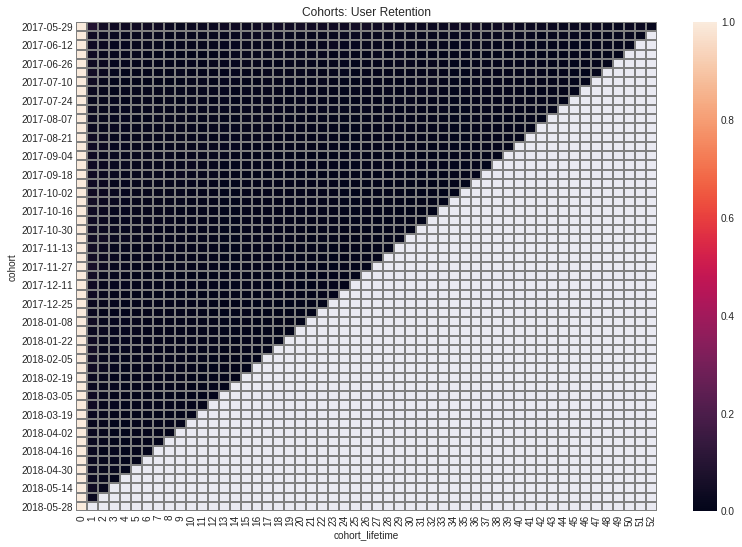

In [0]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, fmt='.1%', linewidths=1, linecolor='gray');

На тепловой карте видно, что в последующие периоды к приложению обращается меньше 20% пользователей когорты.  
 
Плачевная динамика падения ретеншена тут ярко заметна.

In [0]:
retention_pivot1 = retention_pivot.reset_index(drop=True)
retention_pivot1 = retention_pivot1.transpose()
retention_pivot1.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
cohort_lifetime,,,,,,,,,,,,,,,,,,,,,
0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0
1,0.09,0.04,0.04,0.04,0.04,0.05,0.04,0.03,0.02,0.03,...,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.04,0.03,NaN
2,0.05,0.03,0.03,0.02,0.03,0.03,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.01,0.02,0.02,0.02,0.02,NaN,NaN
3,0.04,0.03,0.02,0.02,0.02,0.02,0.01,0.01,0.02,0.02,...,0.01,0.01,0.01,0.02,0.02,0.02,0.01,NaN,NaN,NaN
4,0.04,0.02,0.02,0.02,0.02,0.01,0.01,0.02,0.01,0.02,...,0.01,0.01,0.01,0.01,0.01,0.01,NaN,NaN,NaN,NaN


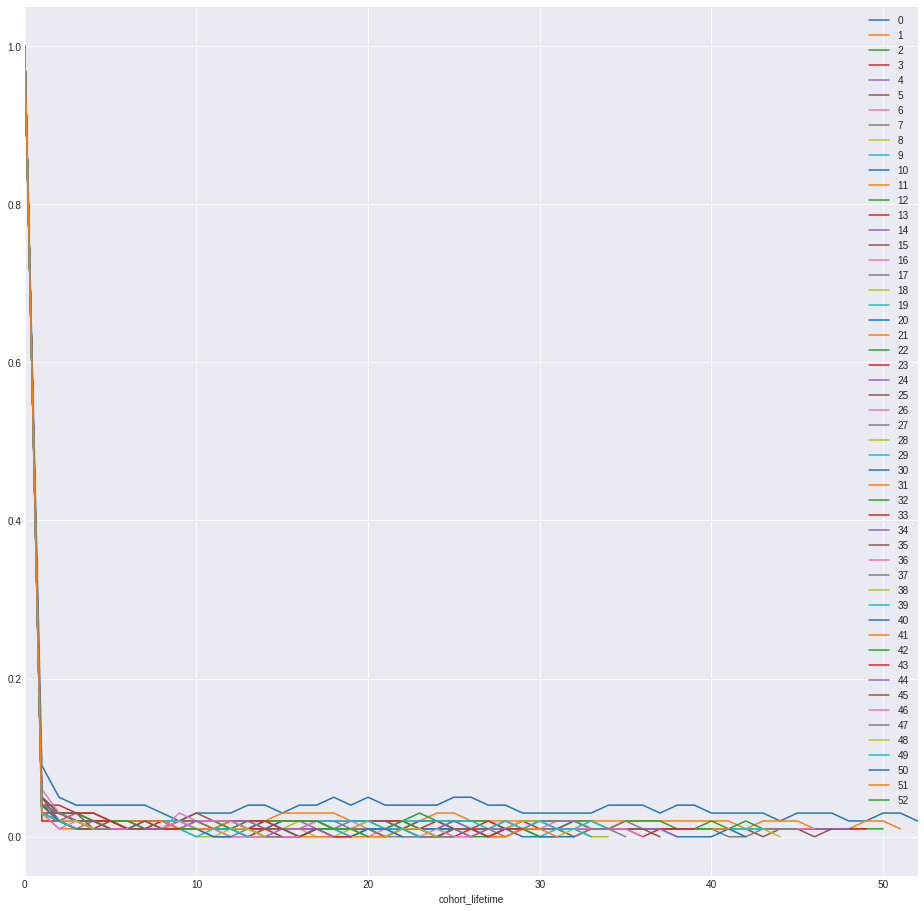

In [0]:
retention_pivot1.plot(figsize=(16, 16), grid=True)

На графике видно, что во всех когортах в последующие периоды retention rate не велик.

<font style="color:#2B9F27; font-size:200%">•</font> **Продажи**

<font style="color:#2B9F27; font-size:200%">•</font> Когда люди начинают покупать?

In [0]:
# Создадим сводную таблицу, в которой найдем дату первой сессии каждого пользователя

first_visit_pivot = visits.pivot_table(index='uid', values='start_ts', aggfunc='min')

# Создадим сводную таблицу, в которой найдем дату первой покупки каждого пользователя

first_order_pivot = orders.pivot_table(index='uid', values='order_date', aggfunc='min')

print('Пользователей приложения: {}'.format(len(first_visit_pivot)))
print('Из них совершило покупку: {}'.format(len(first_order_pivot)))

Пользователей приложения: 228169
Из них совершило покупку: 36523


In [0]:
# Объединим таблицы и найдем время прошедшее от первой сессии до первой покупки

first_visit_order_pivot = first_visit_pivot.merge(first_order_pivot, how='outer', on='uid')
first_visit_order_pivot['time_to_order'] = first_visit_order_pivot['order_date'] - first_visit_order_pivot['start_ts']

# Создадим колонку с количеством минут до покупки

first_visit_order_pivot['minutes_to_order'] = first_visit_order_pivot['time_to_order'].dt.days * 24 * 60 + first_visit_order_pivot['time_to_order'].dt.seconds / 60
first_visit_order_pivot.head()

,start_ts,order_date,time_to_order,minutes_to_order
uid,,,,
11863502262781,2018-03-01 17:27:00,NaT,NaT,NaN
49537067089222,2018-02-06 15:55:00,NaT,NaT,NaN
297729379853735,2017-06-07 18:47:00,NaT,NaT,NaN
313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106 days 23:02:00,154022.0
325320750514679,2017-09-30 14:29:00,NaT,NaT,NaN


In [0]:
first_visit_order_pivot.describe()

,time_to_order,minutes_to_order
count,36523,36523.000000
mean,16 days 21:35:35.732552,24335.595543
std,47 days 01:46:26.123394,67786.435390
min,-1 days +00:59:00,-1381.000000
25%,0 days 00:04:00,4.000000
50%,0 days 00:16:00,16.000000
75%,2 days 00:17:00,2897.000000
max,363 days 07:04:00,523144.000000


В данных есть покупки совершенные до первой сесии.

In [0]:
first_visit_order_pivot.query('minutes_to_order < 0').sample(5)

,start_ts,order_date,time_to_order,minutes_to_order
uid,,,,
7141446460022733181,2017-07-21 16:15:00,2017-07-21 13:43:00,-1 days +21:28:00,-152.0
7681053583481866892,2017-09-09 18:32:00,2017-09-09 16:26:00,-1 days +21:54:00,-126.0
15460601537238301184,2018-03-27 14:35:00,2018-03-27 09:01:00,-1 days +18:26:00,-334.0
16761449191824948290,2017-09-15 10:07:00,2017-09-15 09:00:00,-1 days +22:53:00,-67.0
14410667060854918391,2017-09-29 15:52:00,2017-09-29 11:10:00,-1 days +19:18:00,-282.0


Видимо, стоит составить по этому поводу баг-репорт разработчикам.

In [0]:
# Исключим отрицательные строки из выборки
first_visit_order_pivot = first_visit_order_pivot.query('minutes_to_order >= 0')

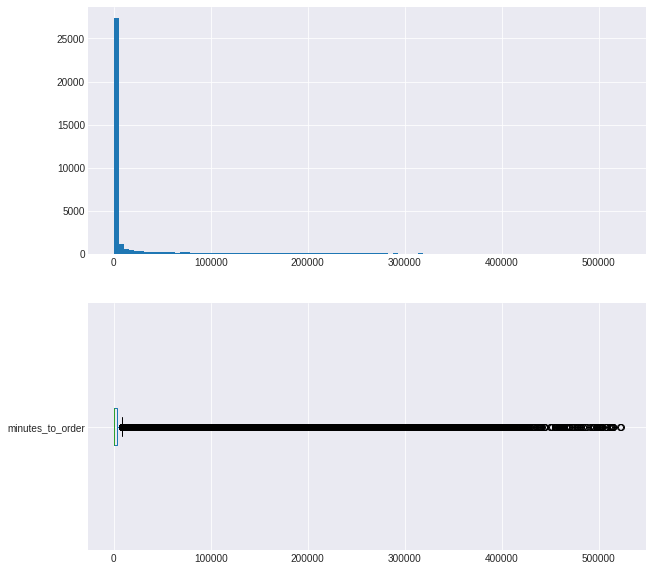

In [0]:
plt.subplots(figsize = (10, 10))
plot = (first_visit_order_pivot['minutes_to_order']
        .hist(bins=100, ax = plt.subplot(2, 1, 1))
       )
plot = (first_visit_order_pivot[['minutes_to_order']]
        .boxplot(vert=False, ax = plt.subplot(2, 1, 2))
       )

В этом случае также смотрим на моду.

In [0]:
first_visit_order_pivot[['minutes_to_order']].mode()

,minutes_to_order
0,1.0


Среднее время от первой сессии до покупки 1 минута.

Также на гистограмме видно, что у нас достаточно много 0 значений. Посмотрим на них.

In [0]:
first_visit_order_pivot.query('minutes_to_order == 0').head()

,start_ts,order_date,time_to_order,minutes_to_order
uid,,,,
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days,0.0
4992223027560440,2018-04-04 13:54:00,2018-04-04 13:54:00,0 days,0.0
40600246103358732,2017-07-21 19:08:00,2017-07-21 19:08:00,0 days,0.0
63518007192153846,2018-03-22 12:16:00,2018-03-22 12:16:00,0 days,0.0
78571833759388849,2017-09-24 18:33:00,2017-09-24 18:33:00,0 days,0.0


Зашли и сразу что-то купили. Почему бы и нет.

<font style="color:#2B9F27; font-size:200%">•</font> Сколько раз покупают за период и какой средний чек?

Посмотрим на помесячное и понедельное количество заказов и средний чек.

In [0]:
# Создадим отдельные столбцы с годом, месяцем и неделей заказа.

orders['order_week'] = orders['order_date'].dt.week
orders['order_month'] = orders['order_date'].dt.month
orders['order_year'] = orders['order_date'].dt.year

# Сгруппируем заказы по месяцам и добавим в отдельный столбец средний чек

orders_by_months = orders.groupby(['order_year', 'order_month']).agg({'uid': 'count','revenue':'sum'})
orders_by_months['revenue_per_user'] = orders_by_months['revenue'] / orders_by_months['uid']

# Сгруппируем заказы по неделям и добавим в отдельный столбец средний чек

orders_by_weeks = orders.groupby(['order_year', 'order_week']).agg({'uid': 'count','revenue':'sum'})
orders_by_weeks['revenue_per_user'] = orders_by_weeks['revenue'] / orders_by_weeks['uid']

In [0]:
orders_by_months

uid   revenue  revenue_per_user
order_year order_month                                  
2017       6            2354   9557.49          4.060106
           7            2363  12539.47          5.306589
           8            1807   8758.78          4.847139
           9            3387  18345.51          5.416448
           10           5679  27987.70          4.928280
           11           5659  27069.93          4.783518
           12           6218  36388.60          5.852139
2018       1            4721  19417.13          4.112927
           2            5281  25560.54          4.840095
           3            5326  28834.59          5.413930
           4            3273  16858.06          5.150645
           5            4346  20735.98          4.771279
           6               1      3.42          3.420000

Данные обрываются в июне 2018 на первой покупке.

Text(0.5, 1.0, 'Количество заказов и средний чек помесячно')

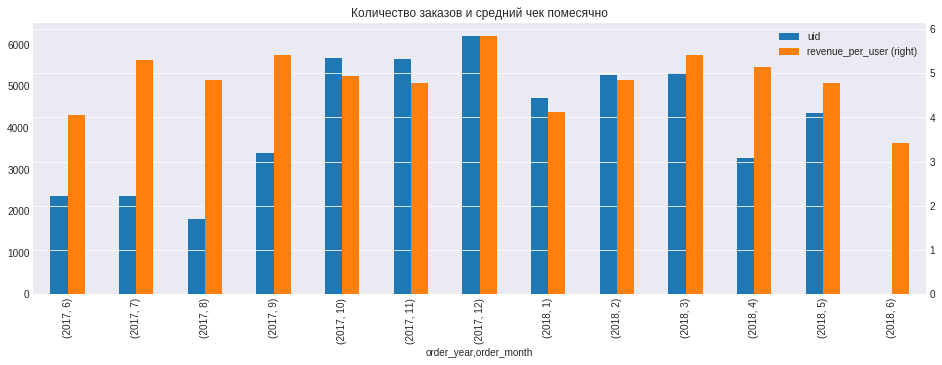

In [0]:
orders_by_months[['uid', 'revenue_per_user']].plot(kind='bar', secondary_y='revenue_per_user', figsize=(16, 5))
plt.title('Количество заказов и средний чек помесячно')

Количество заказов в месяц разное. В августе 2017 - 1807, в декабре - 6218.  
Средний чек более постоянный - колеблется около 4,8.

Информацию по неделям объемная, ее сразу визуализируем.

Text(0.5, 1.0, 'Количество заказов и средний чек по неделям')

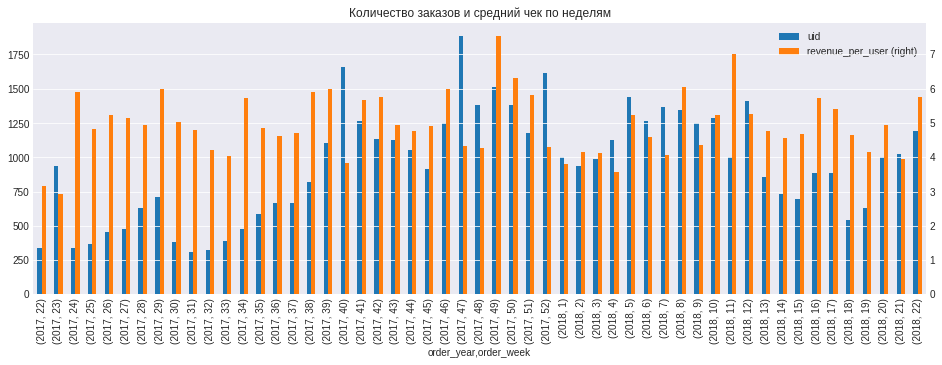

In [0]:
orders_by_weeks[['uid', 'revenue_per_user']].plot(kind='bar', secondary_y='revenue_per_user', figsize=(16, 5))
plt.title('Количество заказов и средний чек по неделям')

In [0]:
orders_by_weeks[['uid','revenue_per_user']].describe()

,uid,revenue_per_user
count,53.000000,53.000000
mean,951.226415,4.951729
std,396.439958,0.904931
min,314.000000,2.914264
25%,636.000000,4.296451
50%,991.000000,4.851616
75%,1257.000000,5.722618
max,1894.000000,7.546664


Количество заказов понедельно разное. На графике видно, что на неделе 2017, 23 резкий скачок, дальше оно опускается до уровня предыдущей недели и плавно растет в течение 5 недель. Падает, снова растет. Надо посмотреть, связаны ли эти скачки с рекламной кампанией.

Средний чек при этом колеблется опять же незначительно 4,8 - 4,9.

In [0]:
# Для каждого клиента получим дату его первого заказа

first_order_date_by_customers = orders.groupby('uid')['order_date'].min()

# Переименуем series, чтобы при добавлении данных в таблицу с покупками не возникало ошибок

first_order_date_by_customers.name = 'first_order_date'

# Добавим дату первой покупки в таблицу с покупками

orders = orders.join(first_order_date_by_customers, on='uid')

# Выделим в отдельный столбцы месяц совершения покупки и первой покупки

orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['order_date'].astype('datetime64[M]')

Сформируем когорты по месяцу первой покупки.

In [0]:
orders_copy = orders.copy()
orders_copy['first_order_month'] = orders_copy['first_order_month'].dt.strftime('%Y-%m')
orders_copy['order_month'] = orders_copy['order_month'].dt.strftime('%Y-%m')

Посмотрим, как изменяется количество покупок внутри одной когорты

In [0]:
orders_pivot = orders_copy.pivot_table(index='first_order_month',
    columns='order_month',
    values='uid',
    aggfunc='count')

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:268: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  fontsize = tick.label.get_size()


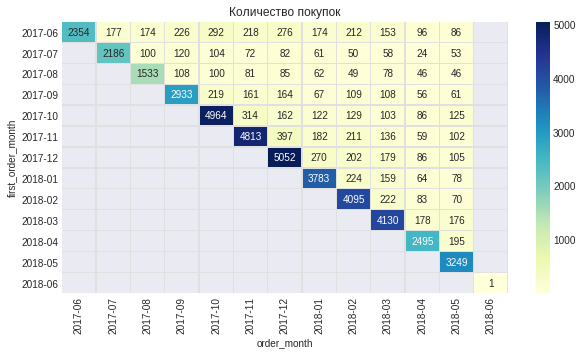

In [0]:
plt.figure(figsize=(10, 5))
plt.title('Количество покупок')
sns.heatmap(orders_pivot, annot=True, fmt='.0f', linewidths=0.3, linecolor='#DFE0DF', cmap="YlGnBu")

* После первого месяца количество покупок в когорте снижается.
* В некоторых когортах число покупок периодически начинает расти. Например, в когорте 2017-06 в сентябре-октябре.
* Количество покупок уменьшается во всех когортах в апреле 2018. Возможно, это связано с сезонностью.

<font style="color:red; font-size:200%">•</font> Как меняется средний чек в когортах?

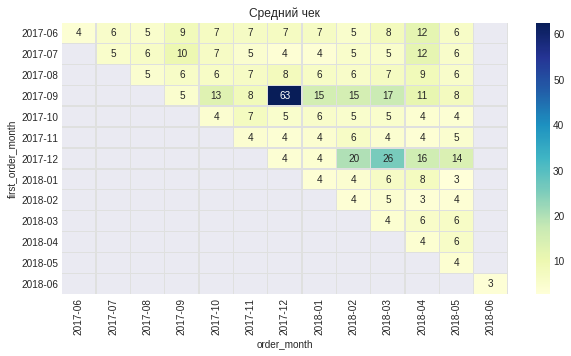

In [0]:
avg_revenue_cohorts = orders_copy.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'count'})
avg_revenue_cohorts['revenue_per_user'] = avg_revenue_cohorts['revenue'] / avg_revenue_cohorts['uid']
avg_revenue_cohorts_pivot = (avg_revenue_cohorts
 .pivot_table(index='first_order_month',columns='order_month',values='revenue_per_user',aggfunc='mean'))
plt.figure(figsize=(10, 5))
plt.title('Средний чек')
sns.heatmap(avg_revenue_cohorts_pivot, annot=True, fmt='.0f', linewidths=0.3, linecolor='#DFE0DF', cmap="YlGnBu")

На этом графике видно, что есть когорты, которые в среднем тратят больше, чем остальные (сентябрьская и декабрьская).  
В сентябрьской когорте есть совсем уж неожиданное число - 63.  
А в апреле (в котором как мы заметили выше, уменьшается количество покупок относительно других месяцев), в некоторых когортах растет средний чек.

<font style="color:#2B9F27; font-size:200%">•</font> Сколько денег приносят? (LTV)

**LTV *(от англ. lifetime value)*** — «пожизненная» ценность клиента. Это — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок. При расчёте LTV обычно обращаются к валовой прибыли с клиента за период.

In [0]:
# Посчитаем количество новых покупателей (n_buyers) за каждый месяц:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
ltv_cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
ltv_cohort_sizes.columns = ['first_order_month', 'n_buyers']
ltv_cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [0]:
# Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
ltv_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
ltv_cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [0]:
# Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц

report = pd.merge(ltv_cohort_sizes, ltv_cohorts, on='first_order_month')

# LTV — относительный показатель. Значит его удобнее смотреть по «возрастным» когортам, где в столбцах — не месяц заказа, 
# а возраст (age) когорты.

report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_order_month,n_buyers,order_month,revenue,age
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4


In [0]:
# Наконец, найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. 

report['ltv'] = report['revenue'] / report['n_buyers']
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round()
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,5.0,0,0,1,1,1,1,1,1,1,1,0
2017-07-01,6.0,0,1,0,0,0,0,0,0,0,0,
2017-08-01,5.0,0,0,0,0,0,0,0,0,0,,
2017-09-01,6.0,1,1,4,0,1,1,0,0,,,
2017-10-01,5.0,1,0,0,0,0,0,0,,,,
2017-11-01,5.0,0,0,0,0,0,0,,,,,
2017-12-01,5.0,0,1,1,0,0,,,,,,
2018-01-01,4.0,0,0,0,0,,,,,,,
2018-02-01,4.0,0,0,0,,,,,,,,


Посчитаем итоговый LTV первой когорты. Сложим их LTV по месяцам:

In [0]:
ltv_201706 = output.loc['2017-06-01'].sum()
ltv_201706

13.0

В среднем каждый покупатель из первой когорты принес по 13,0 выручки за 12 месяцев «жизни».

<font style="color:#C03865; font-size:200%">•</font> **Маркетинг**

<font style="color:#C03865; font-size:200%">•</font> Сколько денег потратили? Всего / на каждый источник / по времени

In [0]:
print('Всего на рекламу потрачено: {}.'.format(costs['costs'].sum()))

Всего на рекламу потрачено: 329131.62.


Text(0.5, 1.0, 'Затраты на маркетинг по источникам')

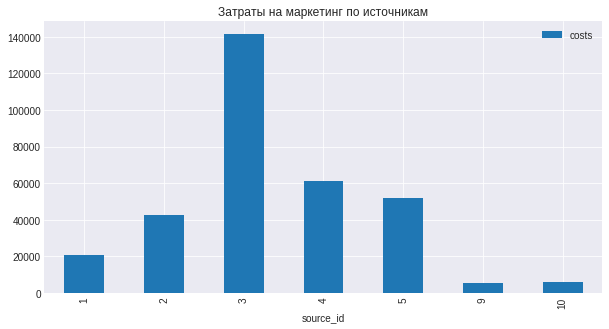

In [0]:
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'})
costs_by_source.plot(kind='bar', figsize=(10, 5))
plt.title('Затраты на маркетинг по источникам')

Больше всего денег вкладывается в 3 источник.

Text(0.5, 1.0, 'Затраты на маркетинг по месяцам')

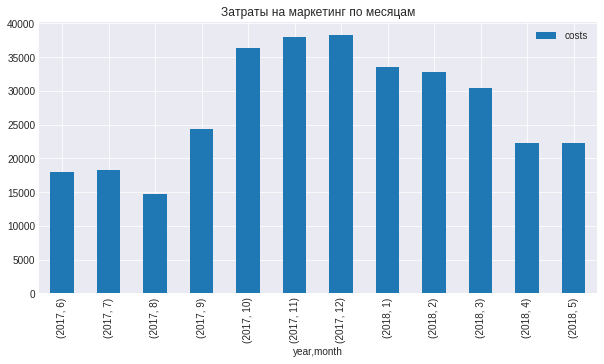

In [0]:
# Создадим отдельные столбцы с годом и месяцем.

costs['week'] = costs['dt'].dt.week
costs['month'] = costs['dt'].dt.month
costs['year'] = costs['dt'].dt.year

# Сгруппируем затраты по месяцам

costs_by_months = costs.groupby(['year', 'month']).agg({'costs':'sum'})

#costs_by_months['index'] = (costs_by_months['costs'] / 38315.35*100).round().astype('int')

costs_by_months.plot(kind='bar', figsize=(10, 5))
plt.title('Затраты на маркетинг по месяцам')

Больше всего денег на маркетинг вложено в декабре.  
На графике видно, что летом на рекламу тратят меньше, осенью-зимой расходы растут, весной снижаются.

Text(0.5, 1.0, 'Затраты на маркетинг по месяцам и источникам')

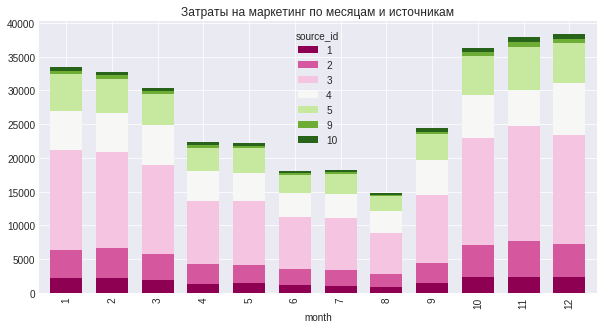

In [0]:
# Сгруппируем затраты по месяцам и источникам
costs_by_months_and_source = costs.pivot_table(index='month', columns='source_id', values='costs',aggfunc='sum')
costs_by_months_and_source.plot(kind='bar', stacked=True, figsize=(10, 5), width=0.7, colormap='PiYG')
plt.title('Затраты на маркетинг по месяцам и источникам')

Затраты по источникам также отличаются в зависимости от месяца размещения рекламы. 
В основном они растут или уменьшаются пропорционально общему закупаемому объему рекламы.
Третий источник на протяжении 12 месяцев занимает самую большую долю затрат.  
В декабре увеличиваются затраты на 4 источник.  
По источинкам 1, 9 и 10 затраты в течение года меняются не значительно.

<font style="color:#C03865; font-size:200%">•</font> Сколько стоило привлечение одного покупателя из каждого источника?

**CAC *(от англ. customer acquisition cost)*** — стоимость привлечения клиента. Сумма денег, во сколько обходится новый клиент компании.

Посмотрим, сколько пользователей привлек каждый источник.

In [0]:
visits_by_source = visits.groupby('source_id').agg({'uid':'nunique'})
visits_by_source

,uid
source_id,
1,18999
2,26245
3,74756
4,83525
5,56974
6,6
7,34
9,9264
10,8067


Рассчитаем, стоимость привлечения одного клиента по каждому источнику. 

In [0]:
cac_by_source = visits_by_source.join(costs_by_source)
cac_by_source.columns = ['n_buyers','costs']
cac_by_source = cac_by_source.fillna(0)
cac_by_source['cac'] = cac_by_source['costs'] / cac_by_source['n_buyers']
cac_by_source

,n_buyers,costs,cac
source_id,,,
1,18999,20833.27,1.096546
2,26245,42806.04,1.631017
3,74756,141321.63,1.890439
4,83525,61073.60,0.731201
5,56974,51757.10,0.908434
6,6,0.00,0.000000
7,34,0.00,0.000000
9,9264,5517.49,0.595584
10,8067,5822.49,0.721766


Text(0.5, 1.0, 'Количество пользователей и САС по источникам')

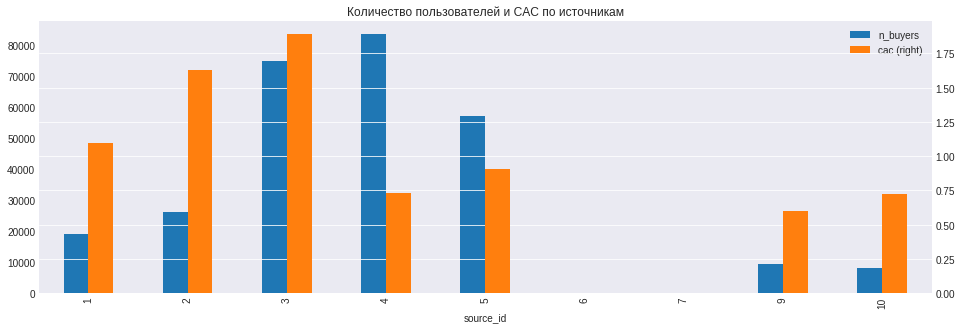

In [0]:
cac_by_source[['n_buyers','cac']].plot(kind='bar',secondary_y='cac', figsize=(16, 5))
plt.title('Количество пользователей и САС по источникам')

* 4 источник приводит на ресурс больше пользователей, чем остальные, при низкой стоимости привлечения.  
* По третьему источнику, как мы выясинили выше, самые высокие затраты, по нему самая высокая стоимость привлечения контакта, но и пользователей он привлекает много.  
* На 6 и 7 источник ничего не тратили, с них пришло очень мало пользователей.

<font style="color:#C03865; font-size:200%">•</font> На сколько окупились расходы? (RO<font style="color:red">M</font>I)

*Чтобы не путать окупаемость бизнеса с окупаемостью маркетинга, вместо ROI рассчитывают ROMI*

Посчитаем CAC первой когорты. Поделим расходы за июнь 2017 на количество людей в когорте:

In [0]:
# отфильруем нужную когорту
cohort_201706 = report[report['first_order_month'] == '2017-06-01']

# посчитаем расходы за этот месяц
costs_201706 = costs[costs['dt'] == '2017-06-01']['costs'].sum()
 
n_buyers_201706 = cohort_201706['n_buyers'][0]
cac_201706 = costs_201706 / n_buyers_201706
ltv_201706   = output.loc['2017-06-01'].sum()
 
print('CAC =', cac_201706)
print('LTV =', ltv_201706)

CAC = 0.3634503213049926
LTV = 13.0


Привлечение одного покупателя в среднем обошлось в 0.36. Валовая прибыль с каждого из них: 13. То есть вложения в привлечение покупателей окупились.

Посчитаем остальные когорты и посмотрим, сколько месяцев нужно каждой когорте, чтобы окупить маркетинговые затраты. Посчитаем CAC каждой когорты. Сначала найдём суммарные расходы за каждый месяц, а затем поделим их на количество покупателей в каждой когорте:


In [0]:
# считаем расходы за месяц
costs['month_cost'] = costs['dt'].astype('datetime64[M]')
monthly_costs = costs.groupby('month_cost').sum()

# Добавим данные о расходах в отчёт и посчитаем CAC:
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month_cost')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']

# Рассчитаем ROMI: поделим LTV на CAC.
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')
 
output.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


Июньская когорта окупилась на 6 месяц (ROMI = 1.05).  
Сентябрьская когорта окупилась на 3 месяц (ROMI = 1.19).  
Остальные когорты еще не окупились.  
Маркетологам нужно что-то менять.

Посчитаем среднюю когорту.

In [0]:
output.cumsum(axis=1).mean(axis=0)

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

В среднем когорта окупается к 8 месяцу.

Посчитаем, сколько денег могут тратить маркетологи на привлечение одного пользователя, если хотят, чтобы вложения окупались за 8 месяцев.

In [0]:
final_result = report_new.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='mean')

m8_cum_ltv = final_result.mean(axis=0).cumsum()[7] # посчитайте накопительный LTV за 6 месяцев после первой покупки

print('Средний LTV за 8 месяцев после первой покупки:', m8_cum_ltv)

Средний LTV за 8 месяцев после первой покупки: 7.945909360906725


Чтобы вложения в маркетинг окупались, привлечение одного покупателя не должно превышать 7,94.